<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Chapters%20Notebooks/Training_a_State_of_the_Art_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Apr  9 08:29:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Installing fastai 
!pip install --upgrade fastai

     |████████████████████████████████| 194kB 10.7MB/s 
     |████████████████████████████████| 12.8MB 229kB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
# Importing the needed packages 
import fastai
print(fastai.__version__)
from fastai.vision.all import * 
from fastai import *

2.3.0


This chapter introduces more advanced techniques for training an Image Classification model and getting state-of-the-art results.

We will be looking at things like: 
- **Normalization** 
- **Mixup**:  a powerful data augmentation technique.
- **test time augmentation**

To do this all this, we're going to to train a model from scratch (not use transfer learning) by using a subset of ImageNet called Imagenette. 

It contains a subset of 10 very different categories from the original ImageNet dataset. 

This is going to be much harder to train because, in here we will use **full size, full-color images, which are photos of dfferent sizes, in different orientations and in different lightning**. 

By this chapter we'll learn how to get most out of our dataset, especially when you're training from scratch, or using transfer learning to train a model on a very different kind of dataset than the pretrained model used. 

### Imagenette 

When fastai started out people used three main datasets from building and testing computer vision models.
- ImageNet
- MNIST
- CIFAR 

The problem was smaller the datasets didn't generalize effectively to the large ImageNet dataset. That's how Imagenetter was created, to get rid of this issue, where people could test their algorithms quickly and cheaply, but that would also provide insights likely to work on the full ImageNet dataset.

Imagenette:
- has 10 classes from the **full ImageNet** that looked very different from one another. The tweaks worked on Imagenette really worked well on ImageNet too. 

> The dataset you are given isn't necessarily the dataset you want. And if it's taking too long to experiment, 
- See how can you cut down your dataset 
- Simplify your model 
to improve the experimentation speed. More the experimentation, the better the results.

In [4]:
# Getting the Imagenette dataset 
path = untar_data(URLs.IMAGENETTE)

In [5]:
# Looking what's in the folder 
path.ls()

(#3) [Path('/root/.fastai/data/imagenette2/train'),Path('/root/.fastai/data/imagenette2/val'),Path('/root/.fastai/data/imagenette2/noisy_imagenette.csv')]

In [6]:
# How many classes are there? 
import os
os.listdir(path/'train')

['n03000684',
 'n03425413',
 'n03028079',
 'n02979186',
 'n02102040',
 'n01440764',
 'n03417042',
 'n03394916',
 'n03445777',
 'n03888257']

In [7]:
# Let's build a DataBlock right away 
dblock = DataBlock(blocks = (ImageBlock() , CategoryBlock()),
                   get_items = get_image_files , 
                   get_y = parent_label , 
                   item_tfms = Resize(460) , 
                   batch_tfms = aug_transforms(size = 224 , min_scale= 0.75))

# Here it goes into our dataloaders 
dls = dblock.dataloaders(path , bs = 64)

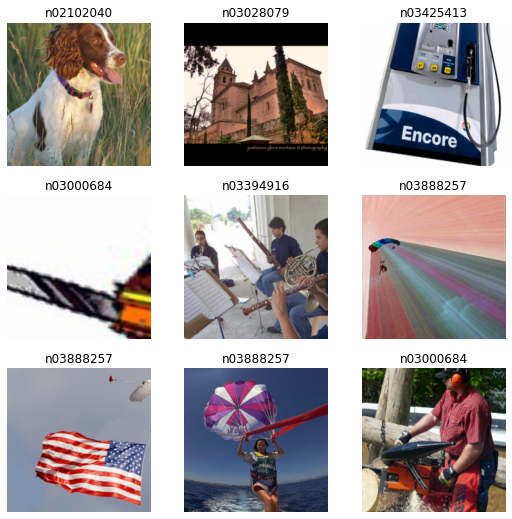

In [8]:
# Visualizing how our data looks? 
dls.show_batch()

In [9]:
# Training a baseline model 
model = xresnet50()
learn = Learner(dls , model , loss_func= CrossEntropyLossFlat() , metrics = accuracy)

# Fitting for 5 epochs 
learn.fit_one_cycle(5 , 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.627300,1.844647,0.439881,05:21
1,1.211741,1.386152,0.578417,05:12
2,0.949933,1.449733,0.528379,05:12
3,0.715869,0.661212,0.794996,05:13
4,0.578398,0.530395,0.827857,05:13


The above is just a baseline model, we are not using a pre-trained model here. 

When working with the models that are being trained from scratch or fine tuned to a very different dataset from the one used for pretraining, some additional techniques are really important. 

## Normalization

Our input data needs to be normalized while we train our model, that is, has a **mean of 0 and standard deviation of 1.**

But most images and computer vision libraries use values ranging between, 
- 0 - 255 
- 0 - 1 for pixels

In either case your data is not goig to have a mean of 0 and standard deviation of 1. 

Let's grab a batch of our data and look at those values, by averaging over all axes except for the channel axis. 

In [10]:
x , y = dls.one_batch()

In [11]:
x.shape , y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [12]:
# Averaging over all axes except the channel
x.mean(dim = [0, 2, 3]) , x.std(dim = [0 , 2, 3])

(TensorImage([0.4529, 0.4534, 0.4254], device='cuda:0'),
 TensorImage([0.2755, 0.2726, 0.2916], device='cuda:0'))

Looking at this we know that the mean and standard deviation are not very close to the desired values. 

We can normalize the values in fastai by just adding the `Normalize` transform. This acts on **whole mini-batch at once**, so you can add it to the `batch_tfms` section of your datablock.

For `Normalize` we gotta pass the mean and std we want to use, but fastai comes with the standard ImageNet mean and standard deviation already defined. 

`imagenet_stats` -->  stats of ImageNet 




In [13]:
# Putting everything into a function (Added Normalization)
def get_dls(bs , size):
  dblock = DataBlock(
      blocks = (ImageBlock() , CategoryBlock()), 
      get_items = get_image_files, 
      get_y = parent_label, 
      item_tfms = Resize(460) , 
      batch_tfms = [*aug_transforms(size= size , min_scale=0.75) , 
                    Normalize.from_stats(*imagenet_stats)]
  )

  return dblock.dataloaders(path , bs = bs)

In [14]:
# Using the function
dls = get_dls(64 , 224)

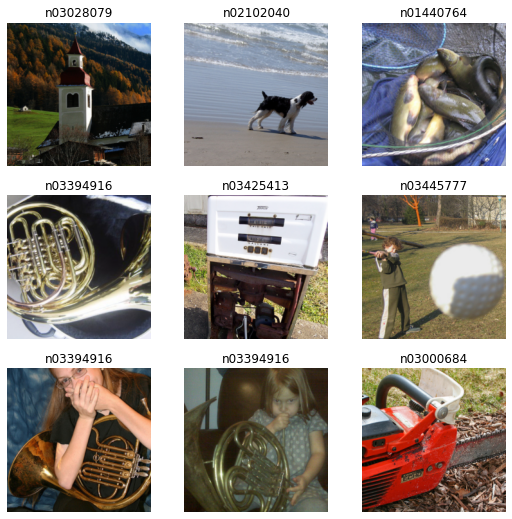

In [21]:
# Visualizing 
dls.show_batch()

Now let's take one mini-batch and chech the mean and standard deviation to see if they're normalized. 

In [20]:
x , y = dls.one_batch() 
x.mean(dim = [0 , 2 ,3]) , x.std(dim = [0 , 2, 3])

(TensorImage([-0.0538, -0.0153,  0.0908], device='cuda:0'),
 TensorImage([1.2677, 1.2624, 1.3368], device='cuda:0'))

In [22]:
# Let's train again but now our data is normalized 
model = xresnet50()
learn = Learner(dls , model , loss_func = CrossEntropyLossFlat() , metrics = accuracy)
learn.fit_one_cycle(5 , 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.671464,1.740457,0.463779,05:15
1,1.249378,1.649338,0.518297,05:14
2,0.993236,1.036054,0.672890,05:14
3,0.755312,0.764005,0.760642,05:14
4,0.609938,0.613577,0.809186,05:14


Look at that!! Before the values wasn't in the range of our expectation. Now looking into the mean and std, it's sure our values are normalized.

Normalization becomes especially important when using pre-trained models because, the pretrained model knows how to work with only data of the type that it has seen before. 

**If the average pixel value was 0 in the data it was trained with, but your data has 0 as minimum possible value of a pixel, then the model is going to be seeing something very different from what is intended**

> If you're using a model that someone else trained, make sure you find out what normalization statistics they used and match them. 

Which means, when you distribute a model you need to also distribute the statistics used for normalization.

In previous chapters we didn't have to handle all these normalizations manually because we're using pre-trained model through `cnn_learner`, so fastai library automatically adds the proper **Normalize** transform.

But in here we didn't use `cnn_learner` instead we used something called `Learner` so we gotta add this normalization informations manually here, when training from scratch. 



## Progressive Resizing

When fastai students won the DAWNBench competition, one of the simple innovation was to **start training using small images, end training using large images**.

- Spending most of the epochs training with small images helps the training complete much faster. 
- Completing training using large image makes the final accuracy much higher. 


---

**Progressive Resizing**: Gradually using larger and larger images as you train

---

#### **How does it work?**

We know how a convolutional neural networks learns, 
- early layers find things like edges and gradients.
- later layers may find things like noses and sunsets from an image. 

So if we change image size in the middle of the training it doesn't mean we have to find totally different parameters for our model. 

In here we are trying to get our model to do something a little bit different from what it has learned to do before, therefore we should be able to use `fine_tune` method after we resize our images. 

Also progressive resizing is **another form of data augmentation**, so we could expect to see **better generalization of our models** that are trained with progressive resizing

#### **How to implement this?**
It will be conveninet with our `get_dls` method where it takes a batch size and image size as arguments and return a `DataLoaders` for us. 
- Create a dataloader with smaller image size. 
- Train it using `fit_one_cycle` for fewer epochs 
- Replace the existing `DataLoaders` with a bit of tweak in the image size, where now use larger image size. 
- Now with that `DataLoaders` train the model with `fine_tune`


Let's see the action in code!

In [24]:
# Creating a dataloaders with smaller image size 
dls = get_dls(bs = 64 , size = 128)

In [26]:
# Creating a learner for the small dls 
learn = Learner(dls , model= xresnet50() , loss_func= CrossEntropyLossFlat(), 
              metrics = accuracy)

In [27]:
# Training the small image size model with fit_one_cycle 
learn.fit_one_cycle(4 , 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.638895,2.096962,0.431292,02:59
1,1.226250,1.616297,0.543316,02:52
2,0.880008,0.834717,0.737117,02:53
3,0.690686,0.689891,0.770724,02:52


In [29]:
# Replacing the existing dataloaders inside the learner, with our large image sized one 
learn.dls = get_dls(64 , size = 224)

In [30]:
# Fine tuning the large image sized one 
learn.fine_tune(5 , 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.754578,0.820999,0.737491,05:14


epoch,train_loss,valid_loss,accuracy,time
0,0.635672,0.609937,0.811800,05:13
1,0.633397,0.728889,0.773338,05:13
2,0.561433,0.565443,0.822255,05:13
3,0.475703,0.491821,0.843540,05:13
4,0.448148,0.483913,0.844287,05:12


Wow! We're getting much better performance, and the initial training on small images was much faster on each epoch. 

We can do this progressive resizing for more number of epochs as we like, but this won't get better when using a larger image size than the original image size. 

For transfer learning, the progressive resizing may actually hurt the performance. This is most likely to happen if your pretrained model is quite similar to your transfer learning task and the dataset and was trained on similar sized images, so the weights don't need to be changed that much. 

On the other hand, if the transfer learning task is going to use images that are of different sizes, shapes or styles than those used in the pretraining task, progressive resizing will probably help.

Another thing we could try is applying **data augmentatio to the validation set**. Until now, we applied the augmentation only on the training set, the validation set always get the same images. 

We could try to make predictions for a few augmented versions of the validation set and average them, this will be our next approach. 